# Sprawozdanie z laboratorium 7

***Autor: Adam Dąbkowski***

Celem siódmego laboratorium jest zaimplementowanie naiwnego klasyfikatora Bayesa. Dodatkowo należy wykorzystać stworzony algorytm do stworzenia i zbadania jakości klasyfikatorów dla zbioru danych ***Cardio Vascular Disease Detection***. Doświadczenia mają zostać przeprowadzone, uwzględniając, zarówno różne podziały na zbiór trenujący, walidacyjny i testowy, jak i różne uruchomienia k-krotnej walidacji krzyżowej (z różnymi podziałami na zbiór treningowy+walidacyjny i testowy) w celu późniejszej oceny, która metoda pomiaru (zbiór walidacyjny czy walidacja krzyżowa) lepiej odzwierciedla wyniki na zbiorach testowych.


## 0. Importowanie niezbędnych bibliotek

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

## 1. Przygotowanie danych

Dane, na których będziemy testowali naszą implementację naiwnego klasyfikatora Bayesa, jest zbiór ***Cardio Vascular Disease Detection***. Jak widać na poniższym listingu, wśród cech znajduje się pole ***id***, które w trakcie uczenia modelu jest niepotrzebne.

In [16]:
data = pd.read_csv('./data/cardio_train.csv', sep=';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [17]:
data.drop(["id"], axis=1, inplace=True)

In [18]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


W analizowanym przez nas zbiorze klasą jest pole ***cardio***. Mając to na uwadze, możemy podzielić nasze na dwa zbiory: zbiór ***X*** (przestrzeń wejść) i zbiór ***y*** (przestrzeń wyjść). Dodatkowo poprzez zastosowanie ***dropna*** usuwane są wiersze z brakującymi danymi.

In [19]:
data.dropna(inplace=True)

In [20]:
X = data.drop('cardio', axis=1)
y = data['cardio']

In [21]:
X.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,22469,1,155,69.0,130,80,2,2,0,0,1
1,14648,1,163,71.0,110,70,1,1,0,0,1
2,21901,1,165,70.0,120,80,1,1,0,0,1
3,14549,2,165,85.0,120,80,1,1,1,1,1
4,23393,1,155,62.0,120,80,1,1,0,0,1


In [22]:
X = X.values
y = y.values

## 2. Implementacja naiwnego klasyfikatora Bayesa

Głównym zadaniem siódmego laboratorium jest implementacja naiwnego klasyfikatora Bayesa. W tym celu stworzona została klasa ***NaiveBayesClassifier***.

Klasa ta zawiera cztery metody:
- ***fit()*** - metoda odpowiedzialna za trenowanie modelu
- ***calc_gaussian_probability()*** - metoda wyznaczająca prawdopodobieństwie wynikające z rozkładu Gaussa
- ***classify()*** - metoda klasyfikująca pojedynczą próbkę
- ***predict()*** - metoda przeprowadzająca klasyfikację dla każdej próbki w danym zestawie

In [23]:
class NaiveBayesClassifier:
    def __init__(self):
        self.X = None
        self.y = None
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)

        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.var = np.zeros((len(self.classes), X.shape[1]))
        self.priors = np.zeros(len(self.classes))

        for i, c in enumerate(self.classes):
            X_c = self.X[np.where(y == c)]
            self.mean[i, :] = X_c.mean(axis=0)
            self.var[i, :] = X_c.var(axis=0)
            self.priors[i] = X_c.shape[0] / X.shape[0]

    def calc_gaussian_probability(self, mean, var, x):
        var_eps = 1e-3
        return (1.0 / np.sqrt(2.0 * np.pi * var + var_eps)) * (np.exp(-((x - mean) ** 2 / (2 * var + var_eps))))

    def classify(self, x):
        posteriors = []

        for i, c in enumerate(self.classes):
            prior = self.priors[i]
            posterior = np.prod(self.calc_gaussian_probability(self.mean[i], self.var[i], x))

            posterior = posterior * prior
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        return [self.classify(x) for x in X]

## 3. Implementacja funkcji pomocniczych

Aby usprawnić analizę otrzymanych wyników, zaimplementowane zostały funkcje pomocnicze ***get_metrics()*** oraz ***plot_confusion_matrix()*** . Pierwsza z nich zwraca wyniki poszczególnych metryk takich jak: dokładność, precyzja, pełność i wynik $F_1$, druga natomiast wyznacza macierz pomyłek dla badanego zbioru.

In [24]:
def get_metrics(y_true, y_pred, printing=True):
    accuracy = round(metrics.accuracy_score(y_true, y_pred), 5)
    precision = round(metrics.precision_score(y_true, y_pred), 5)
    recall = round(metrics.recall_score(y_true, y_pred), 5)
    f1_score = round(metrics.f1_score(y_true, y_pred), 5)

    if printing:
        print("Accuracy: ", accuracy)
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1 score: ", f1_score)

    return [accuracy, precision, recall, f1_score]

In [25]:
def plot_confusion_matrix(y_true, y_pred, set_type="test"):
    cf_matrix = metrics.confusion_matrix(y_true, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, center=True, annot=labels, fmt="", cmap='viridis')
    plt.title(f"Confusion matrix for {set_type} set")
    plt.show()

Aby móc sprawnie badać wpływ wielkości zbiórów oraz współczynnika **k** w przypadku walidacji krzyżowej zaimplementowane zostały także dwie funkcje: ***simulate_standard()*** i ***simulate_cross_validation()*** . Chcąc natomiast w łatwy sposób prezentować i analizować rezultaty działania algorytmu dla poszczególnych przypadków, stworzona została prosta klasa ***Results***.

In [26]:
def simulate_standard(X, y, train_size=0.7):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=train_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

    bayes_clf = NaiveBayesClassifier()
    bayes_clf.fit(X_train, y_train)

    y_val_pred = bayes_clf.predict(X_val)
    metrics_data_val = get_metrics(y_val, y_val_pred)
    plot_confusion_matrix(y_val, y_val_pred, set_type="validation")

    y_test_pred = bayes_clf.predict(X_test)
    metrics_data_test = get_metrics(y_test, y_test_pred)
    plot_confusion_matrix(y_test, y_test_pred, set_type = "test")

    return metrics_data_val, metrics_data_test

In [27]:
def simulate_cross_validation(X, y, train_size=0.6, k=3, print_matrix=True, print_deep=True):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    bayes_clf = NaiveBayesClassifier()

    metrics_data_val = []

    i = 1

    for train_index, val_index in kf.split(X_train_val):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        bayes_clf.fit(X_train, y_train)

        if print_deep:
            print(f"Fold {i}")

        if print_deep:
            print(f"\n------- Validation set -------")

        y_pred_val = bayes_clf.predict(X_val)
        metrics_data_val.append(get_metrics(y_val, y_pred_val, printing=print_deep))

        if print_matrix:
            plot_confusion_matrix(y_val, y_pred_val, set_type = "validation")

        i += 1

    bayes_clf.fit(X_train_val, y_train_val)
    y_pred_test = bayes_clf.predict(X_test)

    metrics_data_test = get_metrics(y_test, y_pred_test, printing=False)
    if print_matrix:
        plot_confusion_matrix(y_test, y_pred_test, set_type = "test")


    metrics_data_val = np.array(metrics_data_val)
    average_accuracy_val = round(np.mean(metrics_data_val[:, 0]), 5)
    average_precision_val = round(np.mean(metrics_data_val[:, 1]), 5)
    average_recall_val = round(np.mean(metrics_data_val[:, 2]), 5)
    average_f1_score_val = round(np.mean(metrics_data_val[:, 3]), 5)


    print(f"***************** Results ({k} folds) *****************")
    print(f"\n---------- Validation set -------")
    print("Average accuracy:", average_accuracy_val)
    print("Average precision:", average_precision_val)
    print("Average recall:", average_recall_val)
    print("Average f1 score:", average_f1_score_val)

    print(f"\n---------- Test set -------------")
    print("Accuracy:", metrics_data_test[0])
    print("Precision:", metrics_data_test[1])
    print("Recall:", metrics_data_test[2])
    print("F1 score:", metrics_data_test[3])

    return [average_accuracy_val, average_precision_val, average_recall_val, average_f1_score_val], [metrics_data_test[0], metrics_data_test[1], metrics_data_test[2], metrics_data_test[3]]

In [28]:
class Results:
    def __init__(self):
        self.results = pd.DataFrame(columns=["Type", "Sets size (training|validation|test)", "Folds number", "Precision (test set)", "Recall (test set)", "F1 score (test set)", "Accuracy (test set)", "Accuracy (validation set)"])

    def update_results(self, type, size, folds, precision_test, recall_test, f1_score_test, accuracy_test, accuracy_val):
        self.results.loc[len(self.results)] = [type, size, folds, precision_test, recall_test, f1_score_test, accuracy_test, accuracy_val]

    def delete_row(self, index):
        self.results.drop([index], axis=0, inplace=True)

    def sort_results(self, column_name):
        self.results = self.results.sort_values(by=[column_name])

    def __repr__(self):
        return self.results.to_string()

## 4. Zastosowanie klasyfikatora

Po zaimplenetowaniu klasyfikatora możemy przejść do jego wykorzystania. Polega ono na stworzeniu i zbadaniu jakości dla zbioru danych ***Cardio Vascular Disease Detection*** . Należy sprawdzić jakość zarówno różnymi podziałami na zbiór trenujący, walidacyjny i testowy, jak i różnymi uruchomieniami k-krotnej walidacji krzyżowej, także w różnej konfiguracji oraz zbadać, która metoda pomiaru (zbiór walidacyjny czy walidacja krzyżowa) lepiej odzwierciedla wyniki na zbiorach testowych.

### 4.1 Podział na zbiór trenujący, walidacyjny i testowy

Na początku rozważmy klasyczny podział na zbiór trenujący, walidacyjny i testowy. Pierwszy z badanych podziałów umożliwi uzyskanie zbioru trenującego, zawierającego **60%** danych, a także walidacyjnego i testowego, gdzie każdy z nich posiadać będzie po **20%** danych.

In [116]:
results_standard = Results()

Accuracy:  0.57633
Precision:  0.73087
Recall:  0.25165
F1 score:  0.37439


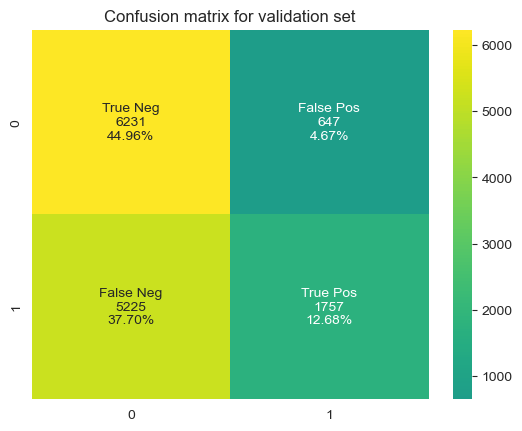

Accuracy:  0.57947
Precision:  0.72139
Recall:  0.25765
F1 score:  0.3797


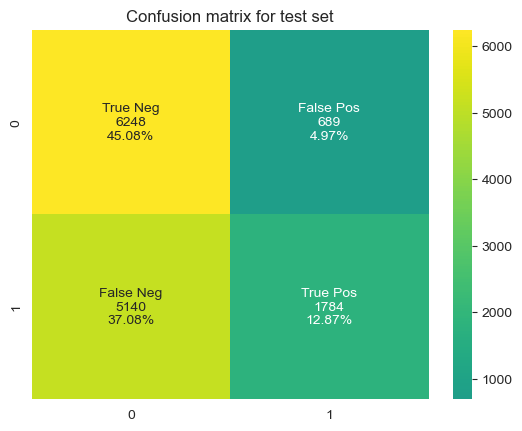

In [117]:
result = simulate_standard(X, y, train_size=0.6)

In [118]:
results_standard.update_results("Standard", "0,6  | 0,2   |   0,2", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Zarówno na zbiorze walidacyjnym jak i testowym osiągnęliśmy zbliżoną nie tylko dokładność ale i wynik $F_1$. Oczywiście można dostrzec, że wspomniane wyniki na zbiorze testowym są minimalnie wyższe, jednakże różnica ta jest bardzo mała. Dzięki wykorzystaniu macierzy pomyłek, widzimy również, że uzyskujemy podobny rozkład w prawidłowym, jak i fałszywym rozpoznaniu próbek. Dodatkowo, nasz klasyfikator cechuje się znacznie większą precyzją niż pełnością, na co wskazuje nie tylko wyświetlony wynik, lecz również pole ***False Neg*** na wyświetlonej macierzy.

Nie znając wyników dla innych podziałów, nie jesteśmy w stanie precyzyjnie określić, czy charakter otrzymanych wyników spowodowany jest specyfiką samego klasyfikatora, czy być może decydujący wpływ wywiera stosunek pomiędzy wielkościami zbiorów. W związku z tym przeprowadzone zostały doświadczenia dla różnych rozmiarów zbiórów, gdzie zbiór treningowy stanowić będzie kolejno ***0,7*** , ***0,8*** , ***0,9***, ***0,95*** wszystkich danych, natomiast zbiory walidacyjny i testowy odpowiednio po ***0,15*** , ***0,1*** , ***0,05*** , ***0,025***.

Accuracy:  0.58461
Precision:  0.72203
Recall:  0.27449
F1 score:  0.39777


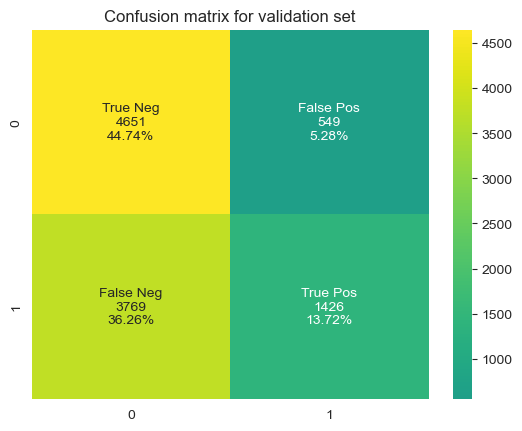

Accuracy:  0.58042
Precision:  0.7208
Recall:  0.26933
F1 score:  0.39214


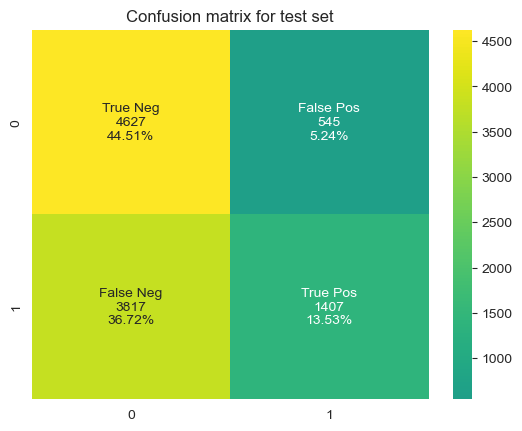

In [119]:
result = simulate_standard(X, y, train_size=0.7)

In [120]:
results_standard.update_results("Standard", "0,7  | 0,15  |  0,15", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Accuracy:  0.58211
Precision:  0.72339
Recall:  0.26822
F1 score:  0.39134


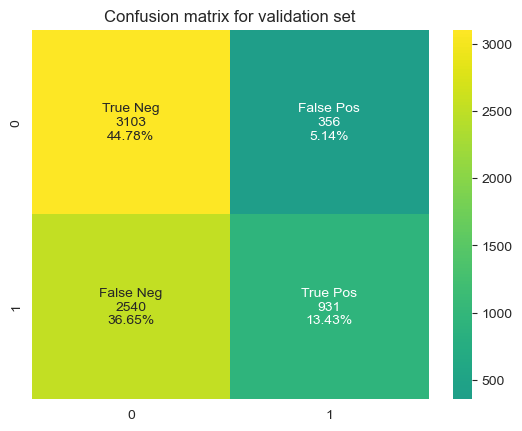

Accuracy:  0.58419
Precision:  0.7182
Recall:  0.27294
F1 score:  0.39555


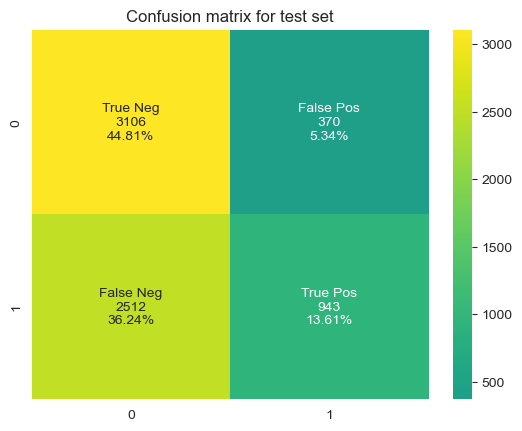

In [121]:
result = simulate_standard(X, y, train_size=0.8)

In [122]:
results_standard.update_results("Standard", "0,8  | 0,1   |   0,1", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Accuracy:  0.58788
Precision:  0.69467
Recall:  0.30291
F1 score:  0.42186


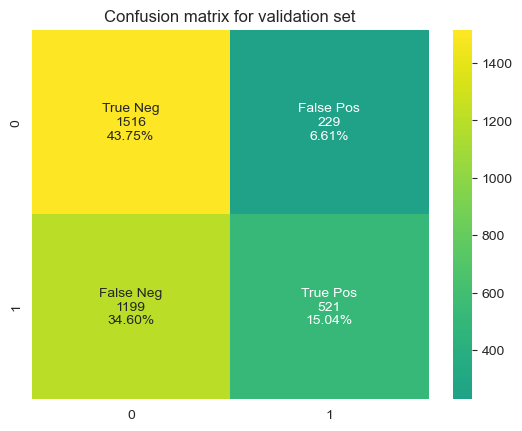

Accuracy:  0.58223
Precision:  0.69717
Recall:  0.29753
F1 score:  0.41707


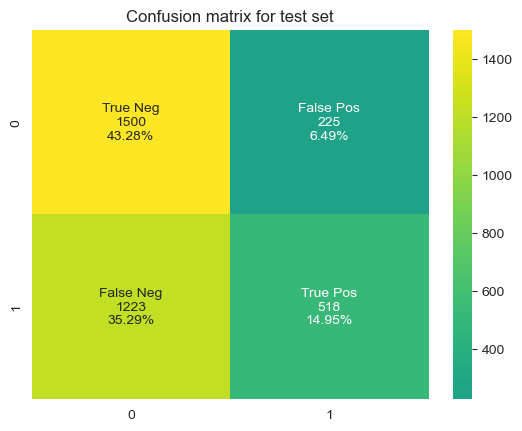

In [123]:
result = simulate_standard(X, y, train_size=0.9)

In [124]:
results_standard.update_results("Standard", "0,9  | 0,05  |  0,05", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Accuracy:  0.57703
Precision:  0.69713
Recall:  0.30204
F1 score:  0.42147


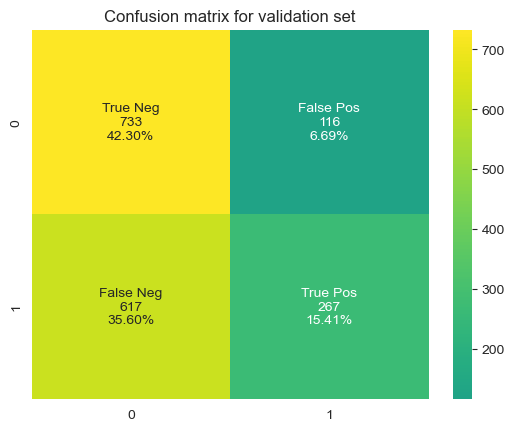

Accuracy:  0.58165
Precision:  0.70604
Recall:  0.30499
F1 score:  0.42597


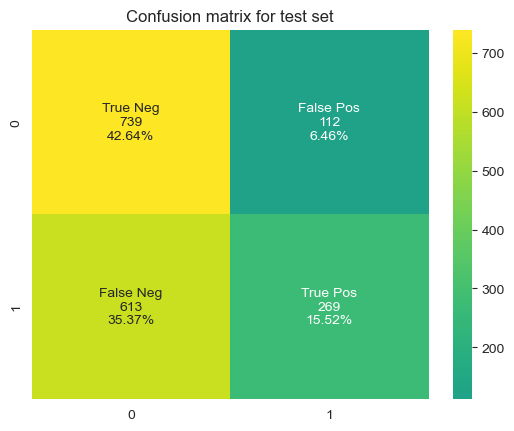

In [125]:
result = simulate_standard(X, y, train_size=0.95)

In [126]:
results_standard.update_results("Standard", "0,95 | 0,025 | 0,025", " ----- ", result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Poniżej zamieszona została zbiorcza tabela zawierająca wyniki dotychczasowych doświadczeń.

In [127]:
results_standard.sort_results("Sets size (training|validation|test)")
results_standard.results

,Type,Sets size (training|validation|test),Folds number,Precision (test set),Recall (test set),F1 score (test set),Accuracy (test set),Accuracy (validation set)
0,Standard,"0,6 | 0,2 | 0,2",-----,0.72139,0.25765,0.37970,0.57947,0.57633
1,Standard,"0,7 | 0,15 | 0,15",-----,0.72080,0.26933,0.39214,0.58042,0.58461
2,Standard,"0,8 | 0,1 | 0,1",-----,0.71820,0.27294,0.39555,0.58419,0.58211
3,Standard,"0,9 | 0,05 | 0,05",-----,0.69717,0.29753,0.41707,0.58223,0.58788
4,Standard,"0,95 | 0,025 | 0,025",-----,0.70604,0.30499,0.42597,0.58165,0.57703


Jak widać powyżej, wielkość zbiorów nie wpływa znacząco na uzyskaną dokładność, jednakże nie można nie wspomnieć, że największą wartość wspomnianej metryki na zbiorze testowym dostajemy dla podziałów ***2*** i ***3***. Jest to spowodowane dostatecznie obszernym zbiorem trenującym, jednak pozostawiającym na tyle dużo próbek wykorzystywanych w zbiorze walidacyjnym i testowym, że otrzymane wyniki są miarodajne, jeśli chodzi o uzyskaną jakość klasyfikatora, ponieważ jednocześnie wskazują na uniezależnienie od czynników losowych podczas podziału, o czym świadczą porównywalne rezultaty dla zbiorów walidacyjnego i testowego. Jedyną próbą, w której w przypadku żadnego zbioru dokładność nie przekroczyła **58%** jest podział **0**. W jego przypadku zbiór trenujący jest zbyt mały, przez co nie jest w stanie dostosować się do większej ilości przypadków, jednakże warto zaznaczyć, że dzięki takiemu podziałowi jesteśmy w stanie ocenić model ze znacznie większą pewnością niż np. w podziale **4**, gdzie wielkość zbiorów walidacyjnego i testowego stanowi jedynie niewielki ułamek tego, co zawiera zbiór trenujący.

O ile wartości dokładności nie odbiegają od siebie znacząco, o tyle dla innych metryk zauważamy pewne zależności. Wraz ze wzrostem wielkości zbioru trenującego obserwujemy wyraźny wzrost pełności. Niestety dzieje się to kosztem uzyskiwanej precyzji, jednakże mimo jej spadku, możemy zaobserwować wzrost wyniku $F_1$, gdyż przyrost pełności jest szybszy.

### 4.2 k-krotna walidacja krzyżowa

Drugim z możliwych podejść jest zastosowanie walidacji krzyżowej. Zbiór danych jest wówczas dzielony na ***k*** fragmentów. Modele trenuje się na ***k-1*** fragmentach, natomiast jakość mierzy się na pozostałym fragmencie. Końcowy rezultat, wynikający z zastosowania niniejszego podejścia, jest uśredniony z ***k*** iteracji, gdzie kolejne z ***k*** fragmentów stają się nowym zbiorem walidacyjnym.


In [128]:
results_cross_validation = Results()

#### 4.2.1 Podział (0,6 | 0,4)

Pierwszym z analizowanych przedziałów jest ten, gdzie ***0,6*** wszystkich danych jest przeznaczonych do trenowania modelu, a co za tym idzie, oceny za pomocą walidacji krzyżowej. Pozostałe ***0,4*** danych będzie zbiorem testowym, który wykorzystamy do oceny po wytrenowaniu modelu i uprzednim przeprowadzeniu walidacji krzyżowej.

W ramach jednego podziału przeprowadzone zostanie kilka odmian walidacji krzyżowej, tzn. zbiór trenujący zostanie podzielony kolejno na ***3, 4, 5, 6, 8, 10*** i ***20*** fragmentów, gdzie uczenie zostanie przeprowadzone na ***k-1*** fragmentach, a jakość się mierzy na pozostałym (jakość ta zostaje potem uśredniona). Jak łatwo się domyślić, wraz ze wzrostem liczby elementów pewność miary jakości jest coraz mniejsza, gdyż fragment, na którym przeprowadzamy ocenę, staje się mniej licznym zbiorem. W drugą stronę, gdy liczba ***k*** jest bardzo mała, narażamy się na niedotrenowanie modelu.

Aby sprawdzić, która wartość ***k*** jest optymalna dla danego podziału, przeprowadzone zostały poniższe doświadczenia.

Fold 1

------- Validation set -------
Accuracy:  0.58261
Precision:  0.75853
Recall:  0.24362
F1 score:  0.36879


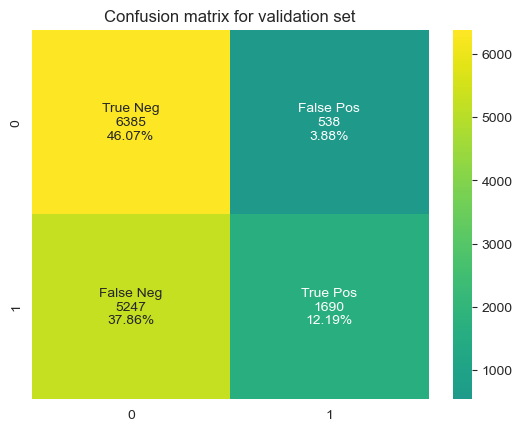

Fold 2

------- Validation set -------
Accuracy:  0.59481
Precision:  0.77749
Recall:  0.26037
F1 score:  0.3901


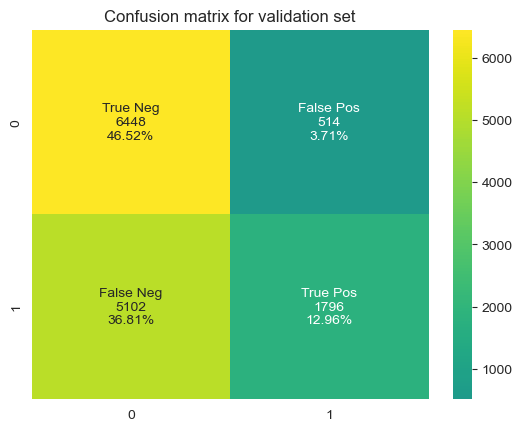

Fold 3

------- Validation set -------
Accuracy:  0.5956
Precision:  0.77735
Recall:  0.26433
F1 score:  0.39451


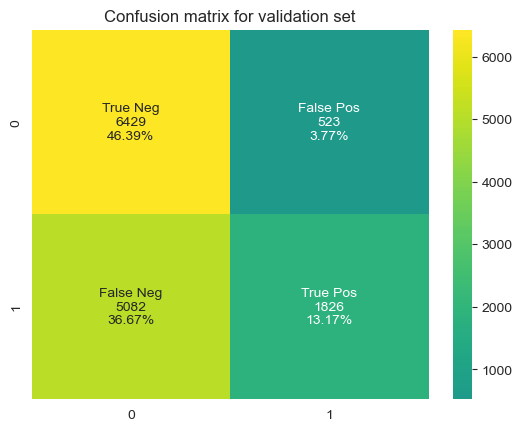

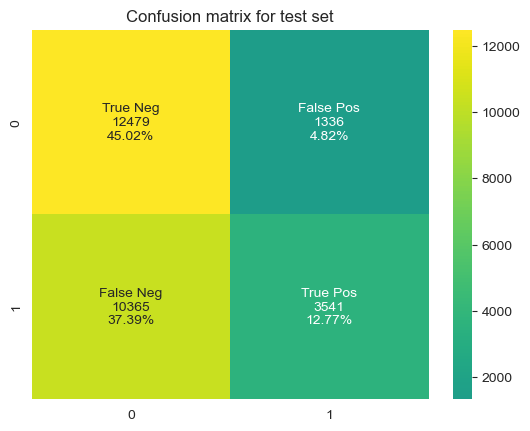

***************** Results (3 folds) *****************

---------- Validation set -------
Average accuracy: 0.59101
Average precision: 0.77112
Average recall: 0.25611
Average f1 score: 0.38447

---------- Test set -------------
Accuracy: 0.5779
Precision: 0.72606
Recall: 0.25464
F1 score: 0.37704


In [129]:
result = simulate_cross_validation(X, y, train_size=0.6, k=3)

In [130]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

Fold 1

------- Validation set -------
Accuracy:  0.5898
Precision:  0.7561
Recall:  0.25301
F1 score:  0.37915


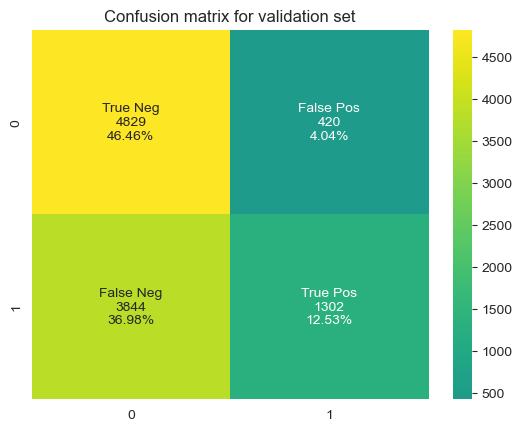

Fold 2

------- Validation set -------
Accuracy:  0.58692
Precision:  0.77665
Recall:  0.24966
F1 score:  0.37786


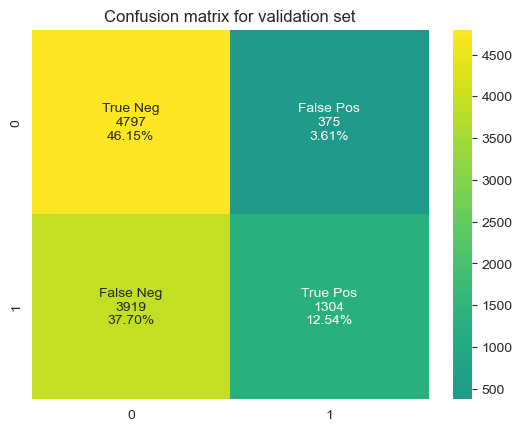

Fold 3

------- Validation set -------
Accuracy:  0.58788
Precision:  0.77531
Recall:  0.2487
F1 score:  0.3766


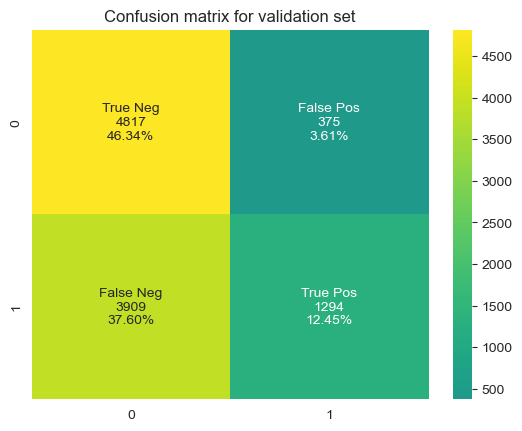

Fold 4

------- Validation set -------
Accuracy:  0.59557
Precision:  0.77087
Recall:  0.2661
F1 score:  0.39563


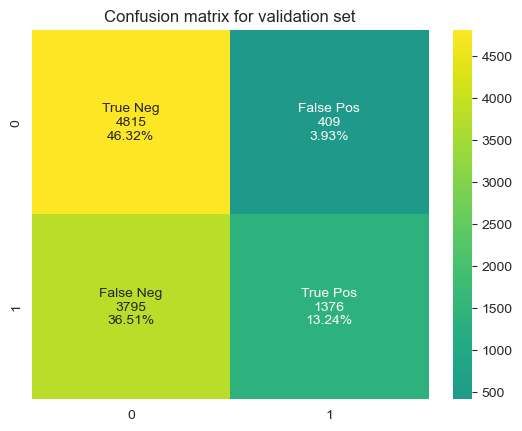

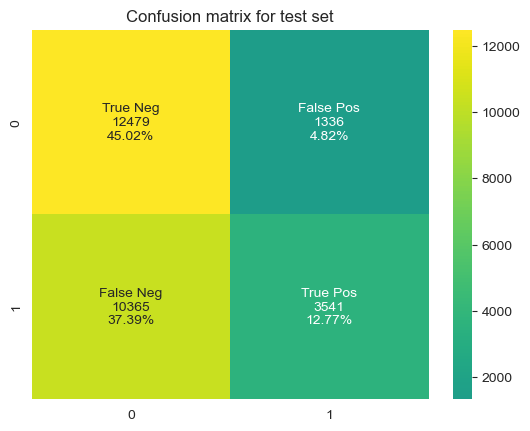

***************** Results (4 folds) *****************

---------- Validation set -------
Average accuracy: 0.59004
Average precision: 0.76973
Average recall: 0.25437
Average f1 score: 0.38231

---------- Test set -------------
Accuracy: 0.5779
Precision: 0.72606
Recall: 0.25464
F1 score: 0.37704


In [131]:
result = simulate_cross_validation(X, y, train_size=0.6, k=4)

In [132]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [133]:
result = simulate_cross_validation(X, y, train_size=0.6, k=5, print_matrix=False, print_deep=False)

***************** Results (5 folds) *****************

---------- Validation set -------
Average accuracy: 0.59043
Average precision: 0.77
Average recall: 0.25538
Average f1 score: 0.38347

---------- Test set -------------
Accuracy: 0.5779
Precision: 0.72606
Recall: 0.25464
F1 score: 0.37704


In [134]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [135]:
result = simulate_cross_validation(X, y, train_size=0.6, k=6, print_matrix=False, print_deep=False)

***************** Results (6 folds) *****************

---------- Validation set -------
Average accuracy: 0.59021
Average precision: 0.76996
Average recall: 0.25471
Average f1 score: 0.38265

---------- Test set -------------
Accuracy: 0.5779
Precision: 0.72606
Recall: 0.25464
F1 score: 0.37704


In [136]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [137]:
result = simulate_cross_validation(X, y, train_size=0.6, k=8, print_matrix=False, print_deep=False)

***************** Results (8 folds) *****************

---------- Validation set -------
Average accuracy: 0.59045
Average precision: 0.77089
Average recall: 0.2549
Average f1 score: 0.38303

---------- Test set -------------
Accuracy: 0.5779
Precision: 0.72606
Recall: 0.25464
F1 score: 0.37704


In [138]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [139]:
result = simulate_cross_validation(X, y, train_size=0.6, k=10, print_matrix=False, print_deep=False)

***************** Results (10 folds) *****************

---------- Validation set -------
Average accuracy: 0.59067
Average precision: 0.77111
Average recall: 0.25501
Average f1 score: 0.38318

---------- Test set -------------
Accuracy: 0.5779
Precision: 0.72606
Recall: 0.25464
F1 score: 0.37704


In [140]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [141]:
result = simulate_cross_validation(X, y, train_size=0.6, k=20, print_matrix=False, print_deep=False)

***************** Results (20 folds) *****************

---------- Validation set -------
Average accuracy: 0.59069
Average precision: 0.77188
Average recall: 0.25479
Average f1 score: 0.3829

---------- Test set -------------
Accuracy: 0.5779
Precision: 0.72606
Recall: 0.25464
F1 score: 0.37704


In [142]:
results_cross_validation.update_results("Cross validation", "0,6  |   0,4", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [143]:
results_cross_validation.results

,Type,Sets size (training|validation|test),Folds number,Precision (test set),Recall (test set),F1 score (test set),Accuracy (test set),Accuracy (validation set)
0,Cross validation,"0,6 | 0,4",3,0.72606,0.25464,0.37704,0.5779,0.59101
1,Cross validation,"0,6 | 0,4",4,0.72606,0.25464,0.37704,0.5779,0.59004
2,Cross validation,"0,6 | 0,4",5,0.72606,0.25464,0.37704,0.5779,0.59043
3,Cross validation,"0,6 | 0,4",6,0.72606,0.25464,0.37704,0.5779,0.59021
4,Cross validation,"0,6 | 0,4",8,0.72606,0.25464,0.37704,0.5779,0.59045
5,Cross validation,"0,6 | 0,4",10,0.72606,0.25464,0.37704,0.5779,0.59067
6,Cross validation,"0,6 | 0,4",20,0.72606,0.25464,0.37704,0.5779,0.59069


Średnie wyniki uzyskane na zbiorach walidacyjnych są praktycznie identyczne. Jest to spowodowane w głównej mierze stosunkowo licznymi fragmentami. Niestety obserwujemy jednocześnie, że dokładność uzyskana dla zbioru testowego jest wyraźnie niższa, na co nie wątpliwie wpływa fakt, że wykorzystywany zbiór testowy, jest zbiorem dużym.

#### 4.2.2 Podział (0,7 | 0,3)

Podobna analiza została przeprowadzona dla podziału, w którym ***0,7*** danych należy do zbioru trenująco-walidacyjnego, natomiast ***0,3*** danych do zbioru testowego.

In [57]:
result = simulate_cross_validation(X, y, train_size=0.7, k=3, print_matrix=False, print_deep=False)

***************** Results (3 folds) *****************

---------- Validation set -------
Average accuracy: 0.59077
Average precision: 0.73674
Average recall: 0.28259
Average f1 score: 0.40764

---------- Test set -------------
Accuracy: 0.58251
Precision: 0.72142
Recall: 0.27191
F1 score: 0.39495


In [58]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [59]:
result = simulate_cross_validation(X, y, train_size=0.7, k=4, print_matrix=False, print_deep=False)

***************** Results (4 folds) *****************

---------- Validation set -------
Average accuracy: 0.58994
Average precision: 0.73353
Average recall: 0.28244
Average f1 score: 0.40701

---------- Test set -------------
Accuracy: 0.58251
Precision: 0.72142
Recall: 0.27191
F1 score: 0.39495


In [60]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [61]:
result = simulate_cross_validation(X, y, train_size=0.7, k=5, print_matrix=False, print_deep=False)

***************** Results (5 folds) *****************

---------- Validation set -------
Average accuracy: 0.5892
Average precision: 0.73142
Average recall: 0.28192
Average f1 score: 0.40596

---------- Test set -------------
Accuracy: 0.58251
Precision: 0.72142
Recall: 0.27191
F1 score: 0.39495


In [62]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [63]:
result = simulate_cross_validation(X, y, train_size=0.7, k=6, print_matrix=False, print_deep=False)

***************** Results (6 folds) *****************

---------- Validation set -------
Average accuracy: 0.58862
Average precision: 0.73098
Average recall: 0.27956
Average f1 score: 0.40382

---------- Test set -------------
Accuracy: 0.58251
Precision: 0.72142
Recall: 0.27191
F1 score: 0.39495


In [64]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [65]:
result = simulate_cross_validation(X, y, train_size=0.7, k=8, print_matrix=False, print_deep=False)

***************** Results (8 folds) *****************

---------- Validation set -------
Average accuracy: 0.58776
Average precision: 0.7291
Average recall: 0.27768
Average f1 score: 0.40195

---------- Test set -------------
Accuracy: 0.58251
Precision: 0.72142
Recall: 0.27191
F1 score: 0.39495


In [66]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [67]:
result = simulate_cross_validation(X, y, train_size=0.7, k=10, print_matrix=False, print_deep=False)

***************** Results (10 folds) *****************

---------- Validation set -------
Average accuracy: 0.58724
Average precision: 0.72817
Average recall: 0.27717
Average f1 score: 0.40115

---------- Test set -------------
Accuracy: 0.58251
Precision: 0.72142
Recall: 0.27191
F1 score: 0.39495


In [68]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [69]:
result = simulate_cross_validation(X, y, train_size=0.7, k=20, print_matrix=False, print_deep=False)

***************** Results (20 folds) *****************

---------- Validation set -------
Average accuracy: 0.58635
Average precision: 0.7256
Average recall: 0.27611
Average f1 score: 0.39976

---------- Test set -------------
Accuracy: 0.58251
Precision: 0.72142
Recall: 0.27191
F1 score: 0.39495


In [70]:
results_cross_validation.update_results("Cross validation", "0,7  |  0,3", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

#### 4.2.3 Podział (0,8 | 0,2)

W kolejnym podziale ***0,8*** danych przypada zbiorowi trenująco-walidacyjnego, jednocześnie zapewniając ***0,2*** danych zbiorowi testowemu.

In [71]:
result = simulate_cross_validation(X, y, train_size=0.8, k=3, print_matrix=False, print_deep=False)

***************** Results (3 folds) *****************

---------- Validation set -------
Average accuracy: 0.58934
Average precision: 0.72327
Average recall: 0.28745
Average f1 score: 0.41138

---------- Test set -------------
Accuracy: 0.58315
Precision: 0.72077
Recall: 0.27057
F1 score: 0.39345


In [72]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [73]:
result = simulate_cross_validation(X, y, train_size=0.8, k=4, print_matrix=False, print_deep=False)

***************** Results (4 folds) *****************

---------- Validation set -------
Average accuracy: 0.59051
Average precision: 0.72104
Average recall: 0.29316
Average f1 score: 0.41592

---------- Test set -------------
Accuracy: 0.58315
Precision: 0.72077
Recall: 0.27057
F1 score: 0.39345


In [74]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [75]:
result = simulate_cross_validation(X, y, train_size=0.8, k=5, print_matrix=False, print_deep=False)

***************** Results (5 folds) *****************

---------- Validation set -------
Average accuracy: 0.58943
Average precision: 0.72135
Average recall: 0.28981
Average f1 score: 0.41333

---------- Test set -------------
Accuracy: 0.58315
Precision: 0.72077
Recall: 0.27057
F1 score: 0.39345


In [76]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [77]:
result = simulate_cross_validation(X, y, train_size=0.8, k=6, print_matrix=False, print_deep=False)

***************** Results (6 folds) *****************

---------- Validation set -------
Average accuracy: 0.59013
Average precision: 0.71935
Average recall: 0.2934
Average f1 score: 0.41606

---------- Test set -------------
Accuracy: 0.58315
Precision: 0.72077
Recall: 0.27057
F1 score: 0.39345


In [78]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [79]:
result = simulate_cross_validation(X, y, train_size=0.8, k=8, print_matrix=False, print_deep=False)

***************** Results (8 folds) *****************

---------- Validation set -------
Average accuracy: 0.5897
Average precision: 0.71955
Average recall: 0.29213
Average f1 score: 0.41512

---------- Test set -------------
Accuracy: 0.58315
Precision: 0.72077
Recall: 0.27057
F1 score: 0.39345


In [80]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [81]:
result = simulate_cross_validation(X, y, train_size=0.8, k=10, print_matrix=False, print_deep=False)

***************** Results (10 folds) *****************

---------- Validation set -------
Average accuracy: 0.58959
Average precision: 0.71917
Average recall: 0.29201
Average f1 score: 0.41491

---------- Test set -------------
Accuracy: 0.58315
Precision: 0.72077
Recall: 0.27057
F1 score: 0.39345


In [82]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [83]:
result = simulate_cross_validation(X, y, train_size=0.8, k=20, print_matrix=False, print_deep=False)

***************** Results (20 folds) *****************

---------- Validation set -------
Average accuracy: 0.58932
Average precision: 0.71929
Average recall: 0.29105
Average f1 score: 0.41408

---------- Test set -------------
Accuracy: 0.58315
Precision: 0.72077
Recall: 0.27057
F1 score: 0.39345


In [84]:
results_cross_validation.update_results("Cross validation", "0,8  |  0,2", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

#### 4.2.4 Podział (0,9 | 0,1)

W tym przypadku zbiór trenująco-walidacyjny jest ***10***-razy większy od zbioru testowego i wynosi ***0,9***.

In [85]:
result = simulate_cross_validation(X, y, train_size=0.9, k=3, print_matrix=False, print_deep=False)

***************** Results (3 folds) *****************

---------- Validation set -------
Average accuracy: 0.59399
Average precision: 0.73155
Average recall: 0.2998
Average f1 score: 0.42112

---------- Test set -------------
Accuracy: 0.58505
Precision: 0.69591
Recall: 0.3002
F1 score: 0.41946


In [86]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [87]:
result = simulate_cross_validation(X, y, train_size=0.9, k=4, print_matrix=False, print_deep=False)

***************** Results (4 folds) *****************

---------- Validation set -------
Average accuracy: 0.59187
Average precision: 0.72952
Average recall: 0.29258
Average f1 score: 0.41601

---------- Test set -------------
Accuracy: 0.58505
Precision: 0.69591
Recall: 0.3002
F1 score: 0.41946


In [88]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [89]:
result = simulate_cross_validation(X, y, train_size=0.9, k=5, print_matrix=False, print_deep=False)

***************** Results (5 folds) *****************

---------- Validation set -------
Average accuracy: 0.59197
Average precision: 0.7284
Average recall: 0.29288
Average f1 score: 0.41664

---------- Test set -------------
Accuracy: 0.58505
Precision: 0.69591
Recall: 0.3002
F1 score: 0.41946


In [90]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [91]:
result = simulate_cross_validation(X, y, train_size=0.9, k=6, print_matrix=False, print_deep=False)

***************** Results (6 folds) *****************

---------- Validation set -------
Average accuracy: 0.58993
Average precision: 0.72082
Average recall: 0.29166
Average f1 score: 0.4147

---------- Test set -------------
Accuracy: 0.58505
Precision: 0.69591
Recall: 0.3002
F1 score: 0.41946


In [92]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [93]:
result = simulate_cross_validation(X, y, train_size=0.9, k=8, print_matrix=False, print_deep=False)

***************** Results (8 folds) *****************

---------- Validation set -------
Average accuracy: 0.58966
Average precision: 0.72119
Average recall: 0.29015
Average f1 score: 0.41356

---------- Test set -------------
Accuracy: 0.58505
Precision: 0.69591
Recall: 0.3002
F1 score: 0.41946


In [94]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [95]:
result = simulate_cross_validation(X, y, train_size=0.9, k=10, print_matrix=False, print_deep=False)

***************** Results (10 folds) *****************

---------- Validation set -------
Average accuracy: 0.58958
Average precision: 0.72084
Average recall: 0.29006
Average f1 score: 0.41348

---------- Test set -------------
Accuracy: 0.58505
Precision: 0.69591
Recall: 0.3002
F1 score: 0.41946


In [96]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [97]:
result = simulate_cross_validation(X, y, train_size=0.9, k=20, print_matrix=False, print_deep=False)

***************** Results (20 folds) *****************

---------- Validation set -------
Average accuracy: 0.58931
Average precision: 0.7194
Average recall: 0.29028
Average f1 score: 0.41346

---------- Test set -------------
Accuracy: 0.58505
Precision: 0.69591
Recall: 0.3002
F1 score: 0.41946


In [98]:
results_cross_validation.update_results("Cross validation", "0,9  |  0,1", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

#### 4.2.5 Podział (0,95 | 0,05)

Na koniec przeprowadzona została analiza dla podziału, w którym ***95%*** danych znajduje się w zbiorze trenująco-walidacyjnym, natomiast ***5%*** danych w zbiorze testowym.

In [99]:
result = simulate_cross_validation(X, y, train_size=0.95, k=3, print_matrix=False, print_deep=False)

***************** Results (3 folds) *****************

---------- Validation set -------
Average accuracy: 0.59271
Average precision: 0.72213
Average recall: 0.30074
Average f1 score: 0.42411

---------- Test set -------------
Accuracy: 0.57934
Precision: 0.70157
Recall: 0.30351
F1 score: 0.42372


In [100]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 3, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [101]:
result = simulate_cross_validation(X, y, train_size=0.95, k=4, print_matrix=False, print_deep=False)

***************** Results (4 folds) *****************

---------- Validation set -------
Average accuracy: 0.59123
Average precision: 0.72186
Average recall: 0.29612
Average f1 score: 0.41935

---------- Test set -------------
Accuracy: 0.57934
Precision: 0.70157
Recall: 0.30351
F1 score: 0.42372


In [102]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 4, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [103]:
result = simulate_cross_validation(X, y, train_size=0.95, k=5, print_matrix=False, print_deep=False)

***************** Results (5 folds) *****************

---------- Validation set -------
Average accuracy: 0.59093
Average precision: 0.721
Average recall: 0.29631
Average f1 score: 0.41931

---------- Test set -------------
Accuracy: 0.57934
Precision: 0.70157
Recall: 0.30351
F1 score: 0.42372


In [104]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 5, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [105]:
result = simulate_cross_validation(X, y, train_size=0.95, k=6, print_matrix=False, print_deep=False)

***************** Results (6 folds) *****************

---------- Validation set -------
Average accuracy: 0.59095
Average precision: 0.72102
Average recall: 0.29616
Average f1 score: 0.41933

---------- Test set -------------
Accuracy: 0.57934
Precision: 0.70157
Recall: 0.30351
F1 score: 0.42372


In [106]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 6, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [107]:
result = simulate_cross_validation(X, y, train_size=0.95, k=8, print_matrix=False, print_deep=False)

***************** Results (8 folds) *****************

---------- Validation set -------
Average accuracy: 0.59057
Average precision: 0.72068
Average recall: 0.29535
Average f1 score: 0.41862

---------- Test set -------------
Accuracy: 0.57934
Precision: 0.70157
Recall: 0.30351
F1 score: 0.42372


In [108]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 8, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [109]:
result = simulate_cross_validation(X, y, train_size=0.95, k=10, print_matrix=False, print_deep=False)

***************** Results (10 folds) *****************

---------- Validation set -------
Average accuracy: 0.59072
Average precision: 0.72092
Average recall: 0.29551
Average f1 score: 0.41887

---------- Test set -------------
Accuracy: 0.57934
Precision: 0.70157
Recall: 0.30351
F1 score: 0.42372


In [110]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 10, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

In [111]:
result = simulate_cross_validation(X, y, train_size=0.95, k=20, print_matrix=False, print_deep=False)

***************** Results (20 folds) *****************

---------- Validation set -------
Average accuracy: 0.59096
Average precision: 0.72147
Average recall: 0.29581
Average f1 score: 0.41933

---------- Test set -------------
Accuracy: 0.57934
Precision: 0.70157
Recall: 0.30351
F1 score: 0.42372


In [112]:
results_cross_validation.update_results("Cross validation", "0,95  |  0,05", 20, result[1][1], result[1][2], result[1][3], result[1][0], result[0][0])

 Poniżej, analogicznie jak wcześniej, zamieszczona została tabela zawierająca wyniki przeprowadzone w omawianym podpunkcie.

In [113]:
results_cross_validation.results

,Type,Sets size (training|validation|test),Folds number,Precision (test set),Recall (test set),F1 score (test set),Accuracy (test set),Accuracy (validation set)
0,Cross validation,"0,6 | 0,4",3,0.72606,0.25464,0.37704,0.57790,0.59101
1,Cross validation,"0,6 | 0,4",4,0.72606,0.25464,0.37704,0.57790,0.59004
2,Cross validation,"0,6 | 0,4",5,0.72606,0.25464,0.37704,0.57790,0.59043
3,Cross validation,"0,6 | 0,4",6,0.72606,0.25464,0.37704,0.57790,0.59021
4,Cross validation,"0,6 | 0,4",8,0.72606,0.25464,0.37704,0.57790,0.59045
5,Cross validation,"0,6 | 0,4",10,0.72606,0.25464,0.37704,0.57790,0.59067
6,Cross validation,"0,6 | 0,4",20,0.72606,0.25464,0.37704,0.57790,0.59069
7,Cross validation,"0,7 | 0,3",3,0.72142,0.27191,0.39495,0.58251,0.59077
8,Cross validation,"0,7 | 0,3",4,0.72142,0.27191,0.39495,0.58251,0.58994
9,Cross validation,"0,7 | 0,3",5,0.72142,0.27191,0.39495,0.58251,0.58920


Podobnie jak w przy podziale na zbiór trenujący, walidacyjny i testowy, z im większym zbiorem trenującym (w tym przypadku "trenująco-walidacyjnym") tym większą obserwujemy nie tylko pełność, ale i wynik $F_1$. Niestety, patrząc na wyniki na zbiorze testowym, nie idzie w pełni w parze z dokładnością, która początkowo rośnie, jednakże dla podziału ***0,95 | 0,05*** ponownie obserwujemy jej spadek. Ciekawa jest natomiast relacja pomiędzy wartościami dokładności na zbiorze testowym, a jej średnim wynikiem dla zbiorów walidacyjnych. Zarówno na początku tabeli, jak i pod koniec obserwujemy większe rozbieżności, podczas gdy w środkowej części tabeli różnice są znacznie mniejsze. Warto również podkreślić, że wyniki uzyskane dla zbiorów walidacyjnych są do siebie zbliżone.

## 5. Podsumowanie

Dla zwiększenia czytelności otrzymanych rezultatów, poniżej została zamieszczona zbiorcza tabela, która przedstawia wyniki powyższych doświadczeń.

In [114]:
results = pd.concat([results_standard.results, results_cross_validation.results])

In [115]:
results

,Type,Sets size (training|validation|test),Folds number,Precision (test set),Recall (test set),F1 score (test set),Accuracy (test set),Accuracy (validation set)
0,Standard,"0,6 | 0,2 | 0,2",-----,0.72139,0.25765,0.37970,0.57947,0.57633
1,Standard,"0,7 | 0,15 | 0,15",-----,0.72080,0.26933,0.39214,0.58042,0.58461
2,Standard,"0,8 | 0,1 | 0,1",-----,0.71820,0.27294,0.39555,0.58419,0.58211
3,Standard,"0,9 | 0,05 | 0,05",-----,0.69717,0.29753,0.41707,0.58223,0.58788
4,Standard,"0,95 | 0,025 | 0,025",-----,0.70604,0.30499,0.42597,0.58165,0.57703
0,Cross validation,"0,6 | 0,4",3,0.72606,0.25464,0.37704,0.57790,0.59101
1,Cross validation,"0,6 | 0,4",4,0.72606,0.25464,0.37704,0.57790,0.59004
2,Cross validation,"0,6 | 0,4",5,0.72606,0.25464,0.37704,0.57790,0.59043
3,Cross validation,"0,6 | 0,4",6,0.72606,0.25464,0.37704,0.57790,0.59021
4,Cross validation,"0,6 | 0,4",8,0.72606,0.25464,0.37704,0.57790,0.59045


Mając na uwadze dotychczasowe obserwacje, a także wyniki zamieszczone w powyższej tabeli, możemy dojść do szeregu wniosków. Pierwszym z nich jest fakt, że wraz ze wzrostem wielkości zbioru trenującego obserwujemy wzrost pełności i wyniku $F_1$, w większości przypadków, kosztem precyzji. Jeśli chodzi o dokładność, to ogólnie rzecz biorąc lepsze wyniki, szczególnie na zbiorze walidacyjnym, osiągamy dla metody walidacji krzyżowej. W jej przypadku liczba ***k*** określająca ilość fragmentów nie wpływa znacząco na uzyskane wyniki, co jest spowodowane w głównej mierze dość dużym zbiorem danych zawierającym ponad ***69000*** próbek. Istotnym czynnikiem, który, podobnie jak dla tradycyjnego podziału na zbiór trenujący, walidacyjny i testowy, wpływa na końcowe rezultaty, jest stosunek wielkości zbiorów. Najlepsze wyniki, dla przykładów wykorzystujących 3 zbiory, uzyskujemy dla podziału, w którym zbiór trenujący zawiera ***80%*** i ***90%*** danych. Podobnie sytuacja wygląda dla doświadczeń wykorzystujących walidację krzyżową. Tutaj bardzo widoczne jest także to, że dla wspomnianych wielkości zbioru treningowego (a tak naprawdę "trenująco-walidacyjnego") różnice pomiędzy dokładnością osiągniętą na zbiorach walidacyjnych i testowych są najmniejsze.